In [1]:
import torch 
import os
import json
import deep_sdf
import deep_sdf.workspace as ws
import scipy.io
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

experiment_directory = "test_experiment"
checkpoint = "210"

specs_filename = os.path.join(experiment_directory, "specs.json")

specs = json.load(open(specs_filename))

arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])

latent_size = specs["CodeLength"]

decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])

decoder = torch.nn.DataParallel(decoder)
decoder.eval()

if torch.cuda.is_available():
    map_location=torch.device('cuda')
else:
    map_location=torch.device('cpu')

saved_model_state = torch.load(
    os.path.join(experiment_directory, ws.model_params_subdir, checkpoint + ".pth"
    ), map_location=map_location
)
saved_model_epoch = saved_model_state["epoch"]

decoder.load_state_dict(saved_model_state["model_state_dict"])

if torch.cuda.is_available():
    decoder = decoder.module.cuda()
else:
    decoder = decoder.module
geom_dimension = decoder.geom_dimension

/usr2/mkofler/.conda/envs/pytorch/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_16676/3935768027.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(xf+x_off, yf+y_off, c=arr,cmap = cm.get_cmap("bone"), vmin=0, vmax=0.1)


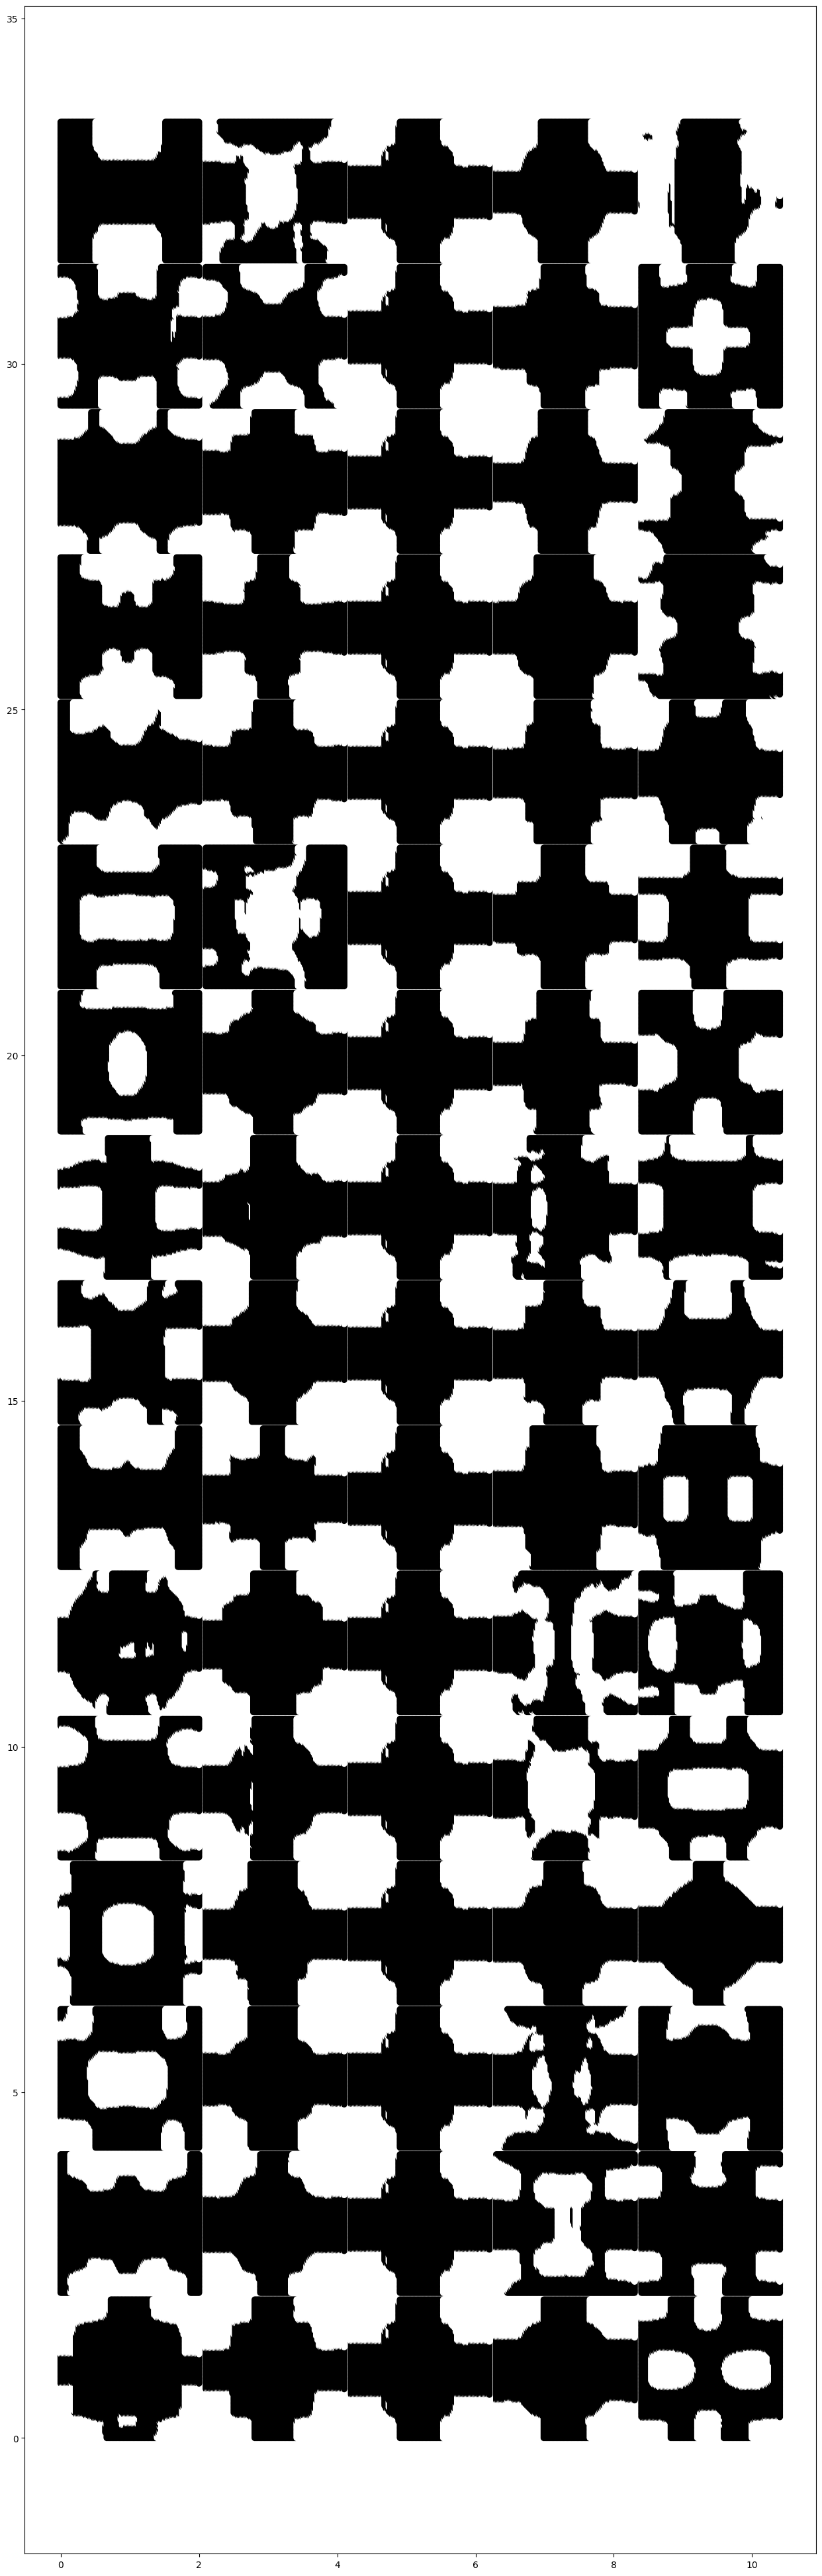

In [2]:
n_plots = (16, 5)
fig, ax = plt.subplots(figsize=(n_plots[0]*5, n_plots[1]*10))
for i in range(n_plots[0]):
    for j in range(n_plots[1]):
        latent = torch.normal(0, 0.5, size=(1,16))[0]
        latent[:] = 0
        latent[i] = 2*j/4 - 1
        x = torch.linspace(-1,1,100)
        y = torch.linspace(-1,1,100)
        xv, yv = torch.meshgrid(x,y)
        
        num_samples = xv.shape[0]*xv.shape[1]
        latent_inputs = latent.expand(num_samples, -1)
        xf, yf = xv.reshape((-1,1)).float(), yv.reshape((-1,1)).float()
        inputs = torch.cat([latent_inputs.float(), xf, yf], 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
        pred_sdf = decoder(inputs)
        
        x_off = 1 + (2+0.1)*(j)
        y_off = 1 + (2+0.1)*(i)
        arr = pred_sdf.cpu().detach().numpy()
        arr[np.where(arr>0)] = 99999
        ax.scatter(xf+x_off, yf+y_off, c=arr,cmap = cm.get_cmap("bone"), vmin=0, vmax=0.1)
        #ax.axis("off")
        #ax.set_title(f"{i}={latent[i].item()}")
        ax.set_aspect(1)
        #ax[i,j].bar(range(16), latent.detach().numpy())
        #ax[1,i].axis("off")
        #ax[i,j].set_ylim(-1,1)

/tmp/ipykernel_16676/3257808936.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(xf+x_off, yf+y_off, c=arr,cmap = cm.get_cmap("bone"), vmin=0, vmax=0.1)


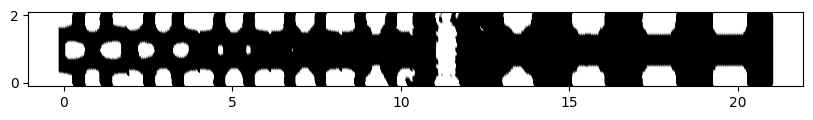

In [25]:
n_plots = (1, 10)
fig, ax = plt.subplots(figsize=(n_plots[0]*10, n_plots[1]*10))
s1 = torch.zeros((1,16))
s2 = torch.zeros((1,16))

s1[0,0] = 1
s2[0,-1] = -1

for i in range(n_plots[0]):
    for j in range(n_plots[1]):
        # latent = torch.nn.functional.interpolate(a, [h*2, w*2], mode='bilinear', align_corners=True)
        nu = (j+1)/n_plots[1]
        latent = s1*(1-nu) + nu*s2
        x = torch.linspace(-1,1,100)
        y = torch.linspace(-1,1,100)
        xv, yv = torch.meshgrid(x,y)
        
        num_samples = xv.shape[0]*xv.shape[1]
        latent_inputs = latent.expand(num_samples, -1)
        xf, yf = xv.reshape((-1,1)).float(), yv.reshape((-1,1)).float()
        inputs = torch.cat([latent_inputs.float(), xf, yf], 1)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
        pred_sdf = decoder(inputs)
        
        x_off = 1 + (2+0.1)*(j)
        y_off = 1 + (2+0.1)*(i)
        arr = pred_sdf.cpu().detach().numpy()
        arr[np.where(arr>0)] = 99999
        ax.scatter(xf+x_off, yf+y_off, c=arr,cmap = cm.get_cmap("bone"), vmin=0, vmax=0.1)
        #ax.axis("off")
        #ax.set_title(f"{i}={latent[i].item()}")
        ax.set_aspect(1)
        #ax[i,j].bar(range(16), latent.detach().numpy())
        #ax[1,i].axis("off")
        #ax[i,j].set_ylim(-1,1)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


/tmp/ipykernel_16676/3334482069.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(xf, yf, c=arr,cmap = cm.get_cmap("bone"), vmin=0, vmax=0.1)


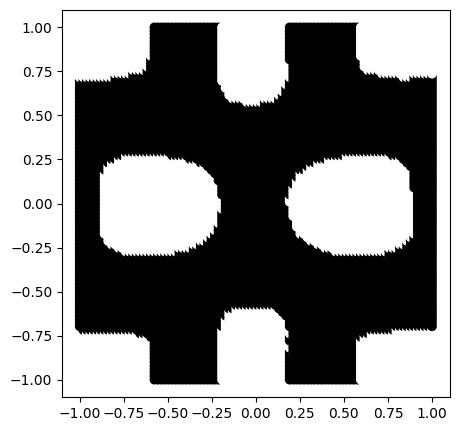

In [21]:
n_plots = (1, 10)
fig, ax = plt.subplots(figsize=(n_plots[0]*5, n_plots[1]*10))
s1 = torch.zeros((1,16))
s2 = torch.zeros((1,16))

s1[0,0] = 1
s2[0,-1] = -1


# latent = torch.nn.functional.interpolate(a, [h*2, w*2], mode='bilinear', align_corners=True)
latent = s1 + (j+1)/n_plots[1]*s2
x = torch.linspace(-1,1,100)
y = torch.linspace(-1,1,100)
xv, yv = torch.meshgrid(x,y)

latent = s1
print(latent)

num_samples = xv.shape[0]*xv.shape[1]
latent_inputs = latent.expand(num_samples, -1)
xf, yf = xv.reshape((-1,1)).float(), yv.reshape((-1,1)).float()
inputs = torch.cat([latent_inputs.float(), xf, yf], 1)
if torch.cuda.is_available():
    inputs = inputs.cuda()
pred_sdf = decoder(inputs)

x_off = 1 + (2+0.1)*(j)
y_off = 1 + (2+0.1)*(i)
arr = pred_sdf.cpu().detach().numpy()
arr[np.where(arr>0)] = 99999
ax.scatter(xf, yf, c=arr,cmap = cm.get_cmap("bone"), vmin=0, vmax=0.1)
#ax.axis("off")
#ax.set_title(f"{i}={latent[i].item()}")
ax.set_aspect(1)

/tmp/ipykernel_16676/4211134912.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[0].scatter(xyz[:,0], xyz[:,1], c=xyz[:,2], cmap = cm.get_cmap("seismic"), vmin=-2, vmax=2)
/tmp/ipykernel_16676/4211134912.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].scatter(xyz[:,0], xyz[:,1], c=pred_sdf.cpu().detach().numpy(),cmap = cm.get_cmap("seismic"), vmin=-2, vmax=2)


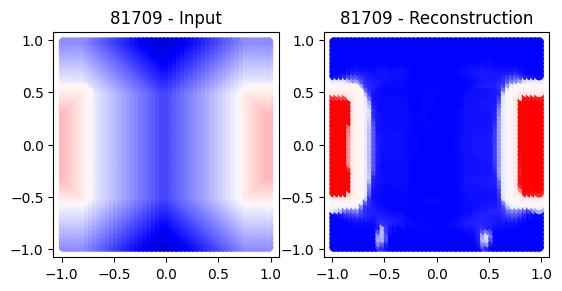

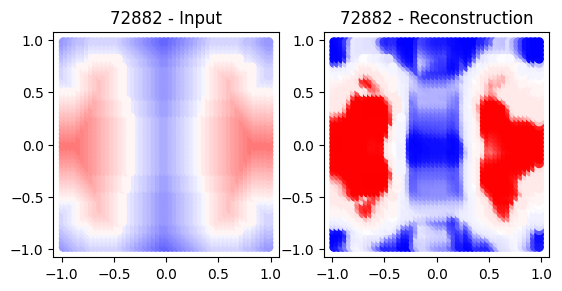

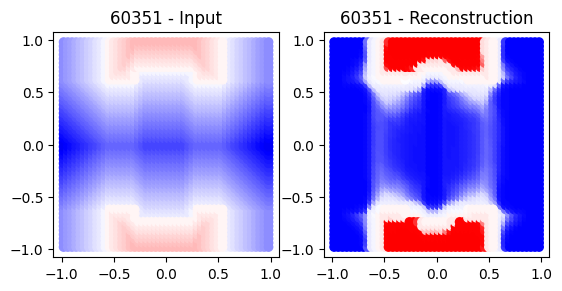

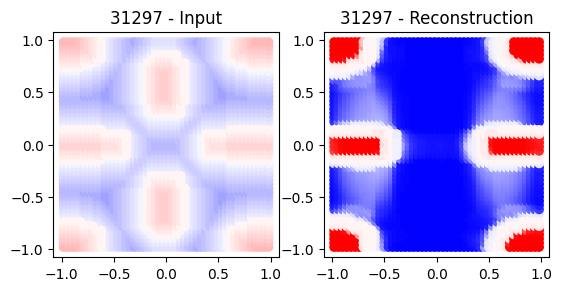

In [12]:
files = [f[:-5] for f in os.listdir(f"./test_experiment/Reconstructions/{checkpoint}/Codes/Wang2021/class1/")]

if len(files) > 4:
    files = random.sample(files, k=4)

for file in files:
    latent = torch.load(f"test_experiment/Reconstructions/{checkpoint}/Codes/Wang2021/class1/{file}..pth")
    npz = np.load(f"data/SdfSamples/Wang2021/class1/{str(file)}.npz")
    neg = torch.from_numpy(npz["neg"]).float()
    pos = torch.from_numpy(npz["pos"]).float()
    xyz = torch.cat([neg, pos], 0)

    xyz_q = xyz[:, 0:2]
    if torch.cuda.is_available():
        xyz_q = xyz_q.cuda()
    num_samples = xyz_q.shape[0]
    latent_inputs = latent[0].expand(num_samples, -1)
    inputs = torch.cat([latent_inputs, xyz_q], 1)
    pred_sdf = decoder(inputs)
    
    fig, ax = plt.subplots(1, 2)

    ax[0].scatter(xyz[:,0], xyz[:,1], c=xyz[:,2], cmap = cm.get_cmap("seismic"), vmin=-2, vmax=2)
    ax[1].scatter(xyz[:,0], xyz[:,1], c=pred_sdf.cpu().detach().numpy(),cmap = cm.get_cmap("seismic"), vmin=-2, vmax=2)
    ax[0].set_aspect(1)
    ax[1].set_aspect(1)
    ax[0].set_title(f"{file} - Input")
    ax[1].set_title(f"{file} - Reconstruction")